In [5]:
from datetime import datetime as dt

import numpy as np

import scipy
from scipy.stats import beta, gamma, norm, binom, uniform, t, lognorm, expon, t
from scipy.optimize import brentq, minimize

import matplotlib.pyplot as plt

# import numdifftools as nd
# from sklearn.linear_model import LinearRegression as linreg
# import sympy as sym

# Importance Sampling (IS)
## Algorithm for non-ratio IS

$E_{x\sim p}[h(x)] =E_{x\sim q}[ \frac{p( x )}{q( x )}h( x )] \approx \frac{1}{N}\sum_{i=1}^N{\frac{p( x_i)}{q( x_i )}h( x_i)}\ =\frac{1}{N}\sum_{i=1}^N{w( x_i) h( x_i)} $ ...... (1) $\qquad$ where $x_i$ are samples from $q(x)$
<br>When we want to estimate something, like $h(x)$ here, we use $E_{x\sim p}[h(x)]$ to do the estimation, where sample data $x$ is from $p(x)$. The $h(x)$ is usually a loss function in deep learning, where we often draw batch_size samples from the dataset and compute loss $h(x)$.
<br>But what if the data distribution $p(x)$ is unknown or difficult to sample, then we can't draw samples $x$ from $p(x)$.
In this case, we can convert it to another distribution $q(x)$ that is builtin function (such as norm, possion) in scipy and easy to draw samples.
<br>
<br> Formula (1) has a problem, it will amplify the variance greatly due to the existence of the ratio $\frac{p( x )}{q( x )}$.
<br> $$Variance = \ E_{x\sim q}[ \frac{p(x)}{q( x )}h( x ) ] ^2- [ E_{x\sim q}[ \frac{p( x )}{q( x )}h(x)]] ^2=E_{x\sim q}[ \frac{p( x )}{q( x )}h( x ) ] ^2-( E_{x\sim p}h(x))^2 $$
<br> When the proposal $q(x)$ is very different from $p(x)$, the variance can be huge.
<br> In order to reduce the variance, there is ratio IS (also call self normalized IS).
## Algorithm for ratio IS (self normalized IS)
Note that $1=E_{x\sim p}[1] =E_{x\sim q}[\frac{p(x)}{q(x)}] \approx \frac{1}{N}\sum_{i=1}^N{w_i}
$
$$E_{x\sim p}[ h( x )] =\frac{\sum_{i=1}^N{w( x_i) h( x_i)}}{\sum_{i=1}^N{w( x_i)}}$$
<br> Although self normalized IS reduced variance, but it's biased estimation, while non-ratio IS is unbiased. But when $N\rightarrow \infty $, self normalized IS tends to be unbiased. Please refer to http://www.webpages.uidaho.edu/~stevel/565/U.%20Bristol/folien3.pdf $\qquad$ https://zhuanlan.zhihu.com/p/260841744
 

## Example (a) 
For $a=2, 4, 6$, calculate $P(X>a)=\int_a^\infty\phi(x)\mathrm{d} x$, where $\phi(x)$ is the PDF of standard normal distribution N(0, 1). 
With 100000 samples, use 
<br> (i) the Monte Carlo approach (draw samples from $\phi(x)$. (Ground Truth)
<br> (ii) the non-ratio version Importance Sampling (simulate samples from the proposal $q(x)=e^{-(x-a)}\mathbf{1}_{[a,\infty)}(x)$) 

(q is easy to sample and avaible in SciPy. and $\phi$ is unable to sample. )

<br> (iii) the ratio version Importance Sampling (simulate samples from the proposal $q(x)=0.5t_4(x)+0.5e^{-(x-a)}\mathbf{1}_{[a,\infty)}(x)$). 

In [2]:
# 1(a) (i)

def integral(a, b):
    N = 100000
    h = (b - a) / float(N) # the width of the slices 
    x = np.linspace(a, b - h, N) + h/2.0 # N points within [a,b]
    area = sum([ h * norm.pdf(t) for t in x]) # area 
    return area

print('Monte Carlo  \t\t\t  Ground Truth')
for a in [2,4,6]:
    print(0.5 - integral(0, a), '\t\t', norm.cdf(-a))

Monte Carlo  			  Ground Truth
0.02275013194637948 		 0.022750131948179195
3.167124179748182e-05 		 3.167124183311986e-05
9.865838701550445e-10 		 9.865876450376946e-10


In [11]:
# 1(a) (ii)
def importance_sample(a):
    N = 100000
    x = expon.rvs(loc=a, size=N)  # expon(loc=a) means e^{-(x-a)} where x>a, the samples x all greater than a
    area = sum(norm.pdf(x) / expon.pdf(x, loc=a))  # why? please refer to page 54 in Lecture 1
    return area / N

print('Non-ratio version IS  \t\t  Ground Truth')
for a in [2,4,6]:
    print(importance_sample(a), '\t\t', norm.cdf(-a))

Non-ratio version IS  		  Ground Truth
0.02267878962784216 		 0.022750131948179195
3.152961388703286e-05 		 3.167124183311986e-05
9.90135763640984e-10 		 9.865876450376946e-10


In [8]:
# 1(a) (iii)
def importance_sample(a):
    # 0.5 in (iii) means half of the time we sample from t distribution, 
    # another half of time we sample from exponential distribution
    N = 100000
    m = binom(n=N, p=0.5).rvs() 
    samples = np.append(t(df=4).rvs(size=m), expon(loc=a).rvs(size=N - m))
    weights = norm.pdf(samples) / (0.5*t(df=4).pdf(samples) + 0.5*expon(loc=a).pdf(samples))
    w3 = (samples > a) * weights
    res = np.mean(w3) / np.mean(weights) # ratio version IS
    return res
    
print('Ratio version IS  \t\t  Ground Truth')
for a in [2,4,6]:
    print(importance_sample(a), '\t\t', norm.cdf(-a))

Ratio version IS  		  Ground Truth
0.022832155723822824 		 0.022750131948179195
3.188603573081571e-05 		 3.167124183311986e-05
9.789295407038135e-10 		 9.865876450376946e-10


## Optimal proposals of importance sampling

Remember that sampling is to generate samples to represent the target distribution $\pi(x)$. In order to reduce the variance of the target distribution and give unbiased estimation, we need to find a optimal proposal function $q(x)$. Different from all the above sampling schemes, the Importance Sampling (IS) generates weighted samples to represent $\pi(x)$. With the proposal distribution $q(x)$ where $x_i$ comes from, we have the non-ratio version weighted samples $\{(x_1,w_1),\dots,(x_n,w_n)\}, w_i=w(x_i)/n$ or the ratio version weighted samples $\{(x_1,w_1),\dots,(x_n,w_n)\}, w_i=w(x_i)/\sum_{i=1}^nw(x_i)$, where $w(x)=\pi(x)/q(x)$ is called the likelihood ratio function or the importance weight function. Here one pair $(x_i,w_i)$, instead of $x_i$, is one single sample. And the ratio version is useful when $\pi(x)$ or $q(x)$ is unnormalized. 

**Think further:** Note that the Rejection Sampling and the Importance Sampling both use the ratio function $w(x)$, so what's the relationship between them? 

Just like before, under some mild conditions, the weighted samples represent the target distribution in the sense that
$$
\hat{\Pi}(x)=\sum_{i=1}^nw_i\mathbf{1}(x_i\le x)\to\mathbb{E}_q[\frac{\pi(X)}{q(X)}\mathbf{1}(X\le x)]=\mathbb{E}_\pi[\mathbf{1}(X\le x)]=\Pi(x)
$$
And also for a function $h(x)$:
$$
\mu=\mathbb{E}_\pi[h(X)]\approx\hat{\mu}=\sum_{i=1}^nw_ih(x_i)
$$
holds for both the ratio and non-ratio weighted samples. 

For the estimator $\hat{\mu}$ with non-ratio weights, we have the asymptotic variance
$$
n\mathrm{Var}_q[\hat{\mu}]\to\mathbb{E}_q[(w(X)h(X)-\mu)^2]=\int\frac{(\pi(x)h(x)-\mu q(x))^2}{q(x)}\mathrm{d}x=\int\frac{(\pi(x)h(x))^2}{q(x)}\mathrm{d}x-\mu^2
$$
Straightly following Jensen’s inequality (https://en.wikipedia.org/wiki/Jensen%27s_inequality), the last expression gives the variance minimizer $q(x)\propto\pi(x)|h(x)|$.

As for the estimator with ratio weights, based on the Delta method (https://en.wikipedia.org/wiki/Delta_method), we can derive the asymptotic variance
$$
n\mathrm{Var}_q[\hat{\mu}]\to\mathbb{E}_q[w(X)^2(h(X)-\mu)^2]=\int\frac{\pi(x)^2(h(x)-\mu)^2}{q(x)}\mathrm{d}x
$$
indicating an optimal proposal $q(x)\propto\pi(x)|h(x)-\mu|$ different from the previous one. 

In the non-ratio version, IS can potentially give us the zero variance estimator if and only if $h(x)$ is always positive or negative on its support. In the ratio version, the asymptotic variance is zero if and only if $h(x)=c$ for a constant $c$, in which case, we don't even need to do the estimation. 


## Example (b)
Calculate the optimal proposals of both non-ratio or ratio version Importance Sampling. Compare the proposals in (a) with the corresponding optimal proposals by plots.

When a = 2


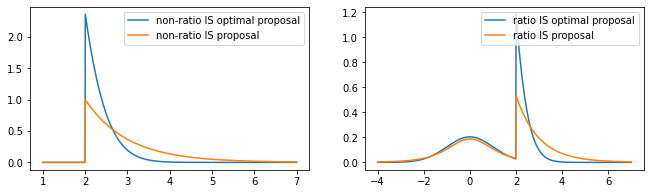

When a = 4


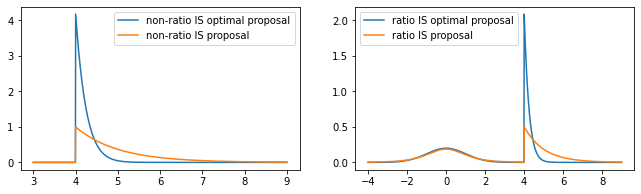

When a = 6


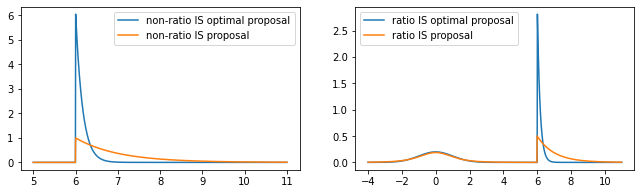

In [12]:
def compare(a):
    truth = norm.cdf(-a)
    print('When a = {}'.format(a))
    
    opt_nrvIS = lambda x: (x > a) * norm.pdf(x) / truth
    opt_rvIS = lambda x: norm.pdf(x) * np.abs((x > a) - truth) / (2 * truth * (1 - truth))
    proposal_nrvIS = expon(loc=a).pdf
    proposal_rvIS = lambda x: 0.5*t(df=4).pdf(x) + 0.5*expon(loc=a).pdf(x)
    
    fig, axs = plt.subplots(1,2,figsize=[11, 3])
    x = np.linspace(a-1, a+5, 1000)
    axs[0].plot(x, opt_nrvIS(x), label='non-ratio IS optimal proposal')
    axs[0].plot(x, proposal_nrvIS(x), label='non-ratio IS proposal')
    axs[0].legend()
    
    x = np.linspace(-4, a+5, 1000)
    axs[1].plot(x, opt_rvIS(x), label='ratio IS optimal proposal')
    axs[1].plot(x, proposal_rvIS(x), label='ratio IS proposal')
    axs[1].legend()
    plt.show()

compare(2)
compare(4)
compare(6)

# Rejection Sampling

Another fundamental important method to draw i.i.d. samples. It generally says that we can generate variable $Y$ from variable $X$ as long as the density of $X$ covers that of $Y$. Or, if we put it another way, variable $X$ can generate any variables whose densities can be covered by the $X$'s density. The spirit of Rejection Sampling actually coincide that of the axiom schema of specification in the set theory (https://en.wikipedia.org/wiki/Axiom_schema_of_specification). Essentially, it says that any definable subclass of a set is a set. People considered it the most important axiom of the set theory as it avoided the famous Russell's paradox (https://en.wikipedia.org/wiki/Russell%27s_paradox). 

**Think further:** Check the axioms in ZFC (a standard set theory system, https://encyclopediaofmath.org/index.php?title=ZFC) to see if there are any other related sampling schemes. 

The procedure of Rejection Sampling (given the target distribution $\pi(x)$ and an envelope distribution $q(x)$):
1. Draw initial samples $\{x_1,\dots,x_m\}$ from $q(x)$, and calculate the corresponding ratios or weights $\{w_1,...,w_m\},w_j=w(x_j)=\pi(x_j)/q(x_j)$; 
2. Calculate $C=\sup w(x)$, and accept each sample $x_j$ with the probability $p_j=w_j/C$ to obtain the final samples $\{x_1^*,\dots,x_n^*\}$. 

There are two ways to do the sampling: 
1. We can start the sampling with $m=1$, and increase $m$ until enough final samples are obtained (each sample only be accepted or rejected once). 
2. Or because the acceptance rate is $1/C$, to obtain $n$ final samples, we can set $m=Cn$ and make a ‘refund for any overpayment or a supplemental payment for any deficiency’ (多退少补). 

* Draw samples from a standard norm distribution based on the t distribution with 1 degree of freedom. Which of the above two sampling methods is faster? (hints: use the 'minimize' function from 'scipy.optimize' (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html); use the 'datetime' package for timing (https://stackoverflow.com/questions/766335/python-speed-testing-time-difference-milliseconds)

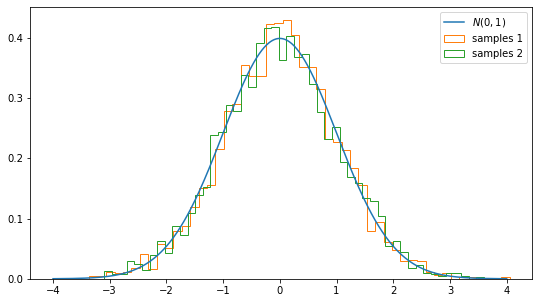

time 1: 5s; time 2: 0s


In [13]:
np.random.seed(1)
weight = lambda x: norm.pdf(x) / t(df=1).pdf(x)
C = weight(minimize(lambda x: -np.log(weight(x)), x0=10, tol=1e-10).x)
n = 3000

# method 1 (start the sampling with  𝑚=1 )
start1 = dt.now()
samples1 = []
while len(samples1) < n:
    new = t(df=1).rvs()
    if uniform.rvs() <= weight(new) / C:
        samples1.append(new)
end1 = dt.now()
time1 = (end1 - start1).seconds

# method 2 (多退少补)
start2 = dt.now()
m = np.ceil(C * n).astype(np.int64)
samples2 = t(df=1).rvs(size=m)
samples2 = samples2[uniform.rvs(size=m) <= weight(samples2) / C]
while samples2.size < n:  # current sample is less than n, generate more. 
    new = t(df=1).rvs()
    if uniform.rvs() <= weight(new) / C:
        samples2 = np.append(samples2, new)
samples2 = samples2[:n] # too many, only use first n samples
end2 = dt.now()
time2 = (end2 - start2).seconds

# plot
xx = np.linspace(-4, 4, 1000)
fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(xx, norm.pdf(xx), label='$N(0, 1)$')
ax.hist(samples1, bins=50, density=True, histtype='step', label='samples 1')
ax.hist(samples2, bins=50, density=True, histtype='step', label='samples 2')
ax.legend()
plt.show()
print('time 1: {}s; time 2: {}s'.format(time1, time2))

## Question ( Rejection Sampling)

* To draw samples from the target distribution $\pi(x)$, remember the procedure of Rejection Sampling (RS): 1) Draw initial samples $\{x_1,\dots,x_m\}$ from an envelope distribution $q(x)$, and calculate the corresponding ratios or weights $\{w_1,...,w_m\},w_j=w(x_j)=\pi(x_j)/q(x_j)$; 2) Calculate $C=\sup w(x)$, and accept each sample $x_j$ with the probability $p_j=w_j/C$ to obtain the final samples $\{x_1^*,\dots,x_n^*\}$. A modified version of RS is to replace $C$ by $\max w_j$.

## (a) 
Obviously the first benefit of replacing $\sup w(x)$ by $\max w_j$ is that it saves efforts to calculate the maximum value especially when the shape of the target or proposal are complicated or non-smooth. Let 
    $\pi(x)=0.5N(x|-2,0.5^2)+0.5N(x|1,1^2)$ be the target and $q(x)=t_1(x)$ be the envelope.
    Plot $w(x)$ and calculate $C$.

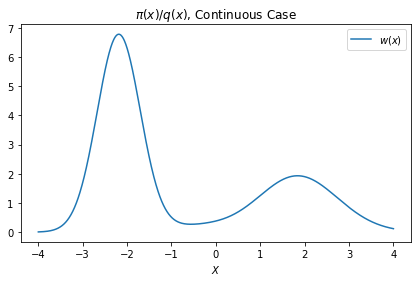

C = 6.780869339580882


In [15]:
pi = lambda x: 0.5*norm(loc=-2, scale=0.5).pdf(x) + 0.5*norm(loc=1, scale=1).pdf(x)
q = t(df=1) # envolope
w = lambda x: pi(x) / q.pdf(x)

x = np.linspace(-4, 4, 1000)
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, w(x), label='$w(x)$')
ax.legend()
plt.title('$\pi(x)/q(x)$, Continuous Case')
plt.xlabel('$X$')
plt.show()

C = w(minimize(lambda x: -np.log(w(x)), x0=-2, tol=1e-10).x[0])
print('C = {}'.format(C))

## (b) 
The acceptance rate for the original RS is $1/C$. As $\max w_j<C$, the modified RS may have higher acceptance rate. Set sample size$m=50, 100, 200, 500, 1000$. Under each $m$, implement these two types of Rejection Sampling 
    with $1000$ replications to estimate and compare their acceptance rates by plotting the acceptance rate vs $\log(m)$.

In [16]:
def rejection(m):
    samples = q.rvs(size=m)
    weights = w(samples)
    acc1 = np.mean(uniform.rvs(size=m) <= weights / C)
    acc2 = np.mean(uniform.rvs(size=m) <= weights / weights.max())
    return acc1, acc2

def experiment(K, m):
    '''
    K: Number of Simulations
    m: Sample Size
    '''
    Acc1 = []
    Acc2 = []
    for k in range(K):
        acc1, acc2 = rejection(m)
        Acc1.append(acc1)
        Acc2.append(acc2)
        
    return np.mean(Acc1), np.mean(Acc2)

1/C = 0.1475, C =  6.780869339580882


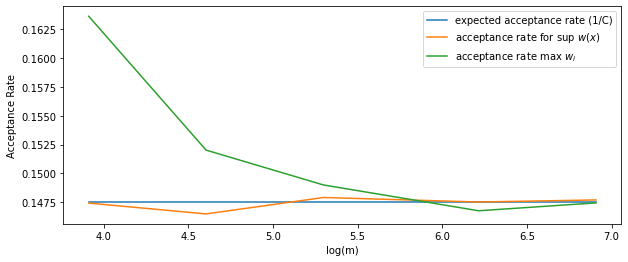

In [17]:
np.random.seed(19971107)
print('1/C = {:.4f}, C = '.format(1/C), C)
M = [50, 100, 200, 500, 1000]
Acc1 = []
Acc2 = []
for m in M:
    acc1, acc2 = experiment(1000, m)
    Acc1.append(acc1)
    Acc2.append(acc2)
    
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot([np.log(M[0]), np.log(M[-1])], [1/C, 1/C], label='expected acceptance rate (1/C)')
ax.plot(np.log(M), Acc1, label='acceptance rate for sup $w(x)$ ')
ax.plot(np.log(M), Acc2, label='acceptance rate max $w_i$')
ax.set_xlabel('log(m)')
ax.set_ylabel('Acceptance Rate')
ax.legend()
plt.show()

$max w_j $ has higher acceptance rate than C = sup$w(x)$, but when $m$ tends to infinite, they tend to have the same acceptance rate.

## (c)
The third advantage is that different from $\sup w(x)$, $\max w_j$ can always be obtained even if the tail of $q(x)$ is lighter than that of $\pi(x)$.
Let $\pi(x)=N(x|0,1^2)$, $q(x)=N(x|0, 3^2)$. Generate over 3000 final samples using the modified version of RS, and plot
the histogram vs the true target $\pi(x)$.

final sample number: 33263/100000 (sigma = 3); acceptance rate: 0.3326


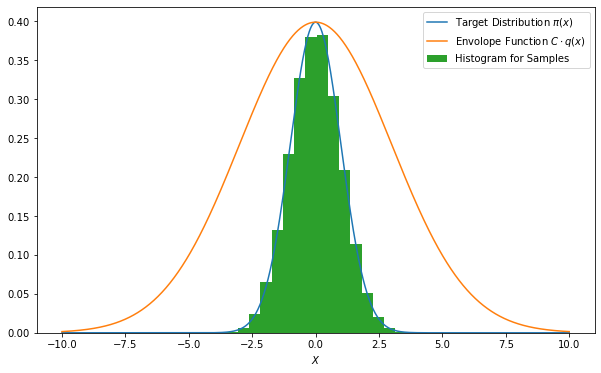

In [18]:
def simulation(sigma, m):
    samples = norm(scale=sigma).rvs(size=m)
    weights = norm.pdf(samples) / norm(scale=sigma).pdf(samples)
    C = weights.max()
    final_samples = samples[uniform.rvs(size=m) <= weights / C]
    print('final sample number: {}/{} (sigma = {}); acceptance rate: {:.4f}'
          .format(final_samples.size, m, sigma, final_samples.size / m))
    
    x = np.linspace(-10, 10, 1000)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x, norm.pdf(x), label='Target Distribution $\pi(x)$')
    ax.plot(x, norm.pdf(x, scale=sigma) * C, label = 'Envolope Function $C\cdot q(x)$')
    ax.hist(final_samples, bins=20, density=True, label='Histogram for Samples ')  # plot final_samples 
    ax.legend()
    ax.set_xlabel('$X$')
    
    plt.show()
    
np.random.seed(19971107)
simulation(3, 100000)

From the picture, we can see we draw samples from $\pi(x)$ successfully.

In [22]:
1/C

0.14747371611525684

# SIR
## SIR without replacement
Sampling procedure:
1. Generate $J$ i.i.d. samples $X^{(1)},\dots, X^{(J)}$ from $g(\cdot)$;
2. Calculate resampling weights $\omega(X^{(j)}) = f(X^{(j)})/g(X^{(j)})$ and probabilities $\omega_j = \frac{\omega(X^{(j)})}{\sum_{j=1}^{J} \omega(X^{(j)})}$ for $j=1,\dots,J$;
3. Select a subset $\{X_{(k_i)}\}_{i=1}^m,~m\leq J$ from $\{X_{(j)}\}_{j=1}^J$ via resampling without replacement with probabilities $\{\omega_j\}_{j=1}^J$.

The reason is: $X^*$
denote by a draw from the discrete distribution over $\{X^{(j)}\}$
placing mass $w_j$ on X(j), 

$P(X^*\leq x^*)=\sum_{j=1}^J w_j I(X^{(j)}\leq x^*)=\frac{\sum_{j=1}^J w(X^{(j)})I(X^{(j)}\leq x^*)}{\sum_{j=1}^J w(X^{(j)})}$ $\to$ $\frac{\int w(x)I(X \leq x^*)g(x)dx}{\int w(x)g(x)dx}=\int_{-\infty}^{x^*} f(x)dx$.

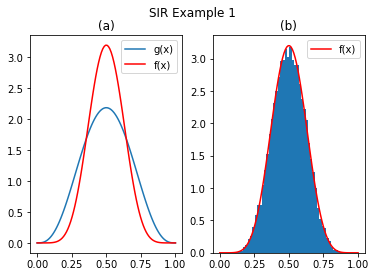

In [20]:
# Parameter Settings
J = 2*10**5
m = 2*10**4
r = 6
# Choose a beta density as the importance sampling g(x)
beta_a=4
beta_b=4
# beta_a=2   #not much difference
# beta_b=4

def f(x, r):
    return np.pi*(np.sin(np.pi*x))**r/scipy.special.beta(0.5, (r+1)/2.0)

# Sampling step
g_samples = np.random.beta(beta_a, beta_b, size=J) # X_1,...X_J ~ g(x)
w = f(g_samples, r)/beta.pdf(g_samples, beta_a, beta_b) # Importance weights
W = w/np.sum(w) # Importance probability
re_sample = np.random.choice(g_samples, size=m, replace=False, p=W) # Resampling without replacement


# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('SIR Example 1')

X = np.linspace(0, 1, 100)
ax1.plot(X, beta.pdf(X, beta_a, beta_b), label='g(x)')
ax1.plot(X, f(X, r), label = 'f(x)', color = 'red')
ax1.legend()
ax1.set_title("(a)")

ax2.hist(re_sample, bins=50, density=True)
ax2.plot(X, f(X, r), label = 'f(x)', color = 'red')
ax2.set_title("(b)")
ax2.legend()

plt.show()

Another example:
1. Target density: $\Gamma(2,2)$ (gamma distribution with a shape parameter 2 and a rate parameter 2).
$$f(x) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1}e^{-\beta x}, \alpha = 2, \beta = 2.$$
2. Use a log-normal distribution Log-Normal(0,1) as the importance sampling density.
$$g(x) = \frac{1}{x\sqrt{2\pi}} e^{-\frac{(\ln x -\mu)^2}{2\sigma^2}}, \mu = 0, \sigma^2 = 1.$$
3. Set $m=10000$ and $J = 200000$.

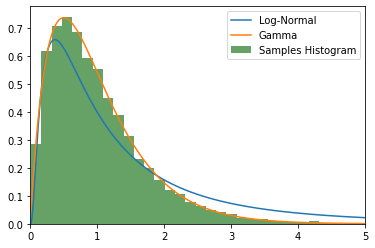

In [21]:
# Parameter settings
m = 10000
J = m*20

# Generate Log-Normal samples
g_samples = np.exp(np.random.normal(0,1,J))

# Compute the weight
gx = ss.lognorm.pdf(g_samples, s=1)
fx = ss.gamma.pdf(g_samples, a=2, scale=1/2) # scale = 1 / rate
w = fx / gx # Importance weights
W = w/np.sum(w) # Importance probabilities

# Resampling
re_sample = np.random.choice(g_samples,size= m , replace = False, p = W)

# Plot
x = np.linspace(np.min(g_samples), np.max(g_samples), m)
plt.plot(x, lognorm.pdf(x,s=1),label='Log-Normal')
plt.plot(x, gamma.pdf(x,a=2,scale=1/2),label='Gamma')
plt.hist(re_sample,label='Samples Histogram', density=True, bins=50, color='darkgreen', alpha=0.6)
plt.xlim(0,5)
plt.legend()
plt.show()
